# K-means Clustering Implementation

Import all of the modules we're going to need...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

First, load the data and take a peek...

In [2]:
DATA_FILEPATH = './data/PSCompPars_2023.09.17_08.49.34.csv'

data = pd.read_csv(DATA_FILEPATH)

In [3]:
print(data.shape)

data.head()

(5514, 36)


,pl_name,hostname,sy_snum,sy_pnum,disc_facility,disc_telescope,pl_orbper,pl_orbsmax,pl_rade,pl_radj,...,rastr,ra,decstr,dec,sy_dist,sy_vmag,sy_kmag,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
0,11 Com b,11 Com,2,1,Xinglong Station,2.16 m Telescope,326.03000,1.290,12.1,1.08,...,12h20m42.91s,185.178779,+17d47m35.71s,17.793252,93.1846,4.72307,2.282,4.44038,0.003848,-0.003848
1,11 UMi b,11 UMi,1,1,Thueringer Landessternwarte Tautenburg,2.0 m Alfred Jensch Telescope,516.21997,1.530,12.3,1.09,...,15h17m05.90s,229.274595,+71d49m26.19s,71.823943,125.3210,5.01300,1.939,4.56216,0.003903,-0.003903
2,14 And b,14 And,1,1,Okayama Astrophysical Observatory,1.88 m Telescope,185.84000,0.830,12.9,1.15,...,23h31m17.80s,352.824150,+39d14m09.01s,39.235837,75.4392,5.23133,2.331,4.91781,0.002826,-0.002826
3,14 Her b,14 Her,1,2,W. M. Keck Observatory,10 m Keck I Telescope,1765.03890,2.774,12.6,1.12,...,16h10m24.50s,242.602101,+43d48m58.90s,43.816362,17.9323,6.61935,4.714,6.38300,0.000351,-0.000351
4,16 Cyg B b,16 Cyg B,3,1,Multiple Observatories,Multiple Telescopes,798.50000,1.660,13.5,1.20,...,19h41m51.75s,295.465642,+50d31m00.57s,50.516824,21.1397,6.21500,4.651,6.06428,0.000603,-0.000603


We have 36 features to work with, which is great.

More information on what each of these columns means can be found on the page linked in the README.

## Data Cleaning & Formatting

In [4]:
data.iloc[0]

pl_name                   11 Com b
hostname                    11 Com
sy_snum                          2
sy_pnum                          1
disc_facility     Xinglong Station
disc_telescope    2.16 m Telescope
pl_orbper                   326.03
pl_orbsmax                    1.29
pl_rade                       12.1
pl_radj                       1.08
pl_bmasse                   6165.6
pl_bmassj                     19.4
pl_bmassprov                 Msini
pl_dens                       19.1
pl_orbeccen                  0.231
pl_insol                       NaN
pl_eqt                         NaN
pl_orbincl                     NaN
ttv_flag                         0
pl_imppar                      NaN
pl_orblper                    94.8
st_spectype                 G8 III
st_teff                     4742.0
st_mass                        2.7
st_lum                       2.243
st_logg                       2.31
rastr                 12h20m42.91s
ra                      185.178779
decstr              

In [5]:
columns_to_drop = [
    'pl_name',
    'hostname',
    'disc_facility',
    'disc_telescope',
]

data = data.drop(columns=columns_to_drop);

Looks like there are some `NaN`, as well as some columns we will need to one-hot encode. There are also time columns. I will definitely have to do some research on the best way to encode time. Something I'm guessing one would need to consider when encoding time is the fact that, for example, 5:30PM is not quantitatively *more* than 5:00PM. Sure, one time comes after the other but I would argue it's closer to a nominal or ordinal scale than an interval or ratio scale in some cases. I think one could argue that the model you apply to the data will learn to work with whatever you gave it. I guess really what I'm arguing is that there is more than one way to encode time. Whereas, there is only one way to encode a boolean. In certain cases, you might want to consider how time is encoded, so I definitely think it's worth looking into.

In [6]:
data.iloc[0]

sy_snum                       2
sy_pnum                       1
pl_orbper                326.03
pl_orbsmax                 1.29
pl_rade                    12.1
pl_radj                    1.08
pl_bmasse                6165.6
pl_bmassj                  19.4
pl_bmassprov              Msini
pl_dens                    19.1
pl_orbeccen               0.231
pl_insol                    NaN
pl_eqt                      NaN
pl_orbincl                  NaN
ttv_flag                      0
pl_imppar                   NaN
pl_orblper                 94.8
st_spectype              G8 III
st_teff                  4742.0
st_mass                     2.7
st_lum                    2.243
st_logg                    2.31
rastr              12h20m42.91s
ra                   185.178779
decstr            +17d47m35.71s
dec                   17.793252
sy_dist                 93.1846
sy_vmag                 4.72307
sy_kmag                   2.282
sy_gaiamag              4.44038
sy_gaiamagerr1         0.003848
sy_gaiam

These columns aren't really what I was expecting and a lot of them are information that is really unfamiliar to me, so I think it will be beneficial to explore it more and see what each column looks like. This is more EDA than I would usually do.

I'm specifically interested in the `pl_bmassprov` column. According to the website, this column is "Planet Mass or Mass*sin(i) Provenance". I'm not sure why this datapoint has `Msini` in this column.

In [7]:
view_columns = [
    'sy_snum',
    'sy_pnum',
    'ttv_flag',
    'spectype',
    'pl_bmassprov'
]
    
for key in view_columns:
    if key not in data.columns:
        continue
    print(f'Column: {key}')
    print(data[key].unique())

Column: sy_snum
[2 1 3 4]
Column: sy_pnum
[1 2 3 5 4 6 8 7]
Column: ttv_flag
[0 1]
Column: pl_bmassprov
['Msini' 'Mass' 'Msin(i)/sin(i)' 'M-R relationship']


Looks like `pl_bmassprov` can be one-hot encoded.

Also, very surprised we are looking at solar systems with 4 stars. I was not aware that happened.

After all that talk about how to encode time, I didn't consult any sources and I've decided to just encode it into miliseconds.

For the rest of this section, here are the things we need to do:

* Encode the time columns
* One-hot encode the appropriate columns
* Fill in null values
* Look at mean, median, etc.
* Normalize the data

### Encoding Time Columns

We need to encode the columns `rastr` and `decstr` into miliseconds in order for them to be usable.

In [8]:
print(data['rastr'].iloc[:100])
print(data['decstr'].iloc[:100])

0     12h20m42.91s
1     15h17m05.90s
2     23h31m17.80s
3     16h10m24.50s
4     19h41m51.75s
          ...     
95    06h44m12.63s
96    18h42m40.11s
97    18h39m07.84s
98    06h47m41.41s
99    06h47m41.41s
Name: rastr, Length: 100, dtype: object
0     +17d47m35.71s
1     +71d49m26.19s
2     +39d14m09.01s
3     +43d48m58.90s
4     +50d31m00.57s
          ...      
95    -00d17m56.96s
96    +06d13m09.00s
97    +04d21m27.91s
98    -03d43m09.44s
99    -03d43m09.44s
Name: decstr, Length: 100, dtype: object


In [9]:
def time_to_ms(value):

    # determine if the value will be positive or negative
    is_positive = value[0] != '-'
    
    # remove negative or postitive signs
    value = value.replace('-', '')
    value = value.replace('+', '')
    
    # create a dictionary containing
    # the value for each time unit
    time_dict = dict()

    # list of time-unit-denoting characters
    # in order from largest to smallest
    unit_chars = ['d', 'h', 'm', 's']
    conversions = {
        'd': 86_400_000,
        'h': 3_600_000,
        'm': 60_000,
        's': 1_000
    }
    unit_char_idx = 0
    curr_amt = ''
    
    for char in value:
        if char.isnumeric():
            curr_amt += char
        elif char.isalpha():
            if char in unit_chars:
                time_dict[char] = curr_amt
                curr_amt = ''
        else:
            # ignoring this character?
            pass

    time_ms = 0
    for key, value in time_dict.items():
        time_ms += conversions[key] * int(value)

    return time_ms if is_positive else -time_ms
        

# test the function we just wrote
assert time_to_ms('2h5m13s') == 7_513_000
assert time_to_ms('1h') == 3_600_000
assert time_to_ms('0') == 0
assert time_to_ms('2h3m') == 7_380_000
assert time_to_ms('-4d') == -345_600_000

I'm goated for this ^^ actually...did not think it was going to work...

In [10]:
data['rastr'], data['decstr'] = data['rastr'].apply(time_to_ms), data['decstr'].apply(time_to_ms)

In [11]:
data['decstr'].describe()

count    5.514000e+03
mean     1.688644e+09
std      3.047168e+09
min     -7.605220e+09
25%     -6.095500e+08
50%      3.377713e+09
75%      3.892490e+09
max      7.350775e+09
Name: decstr, dtype: float64

In [12]:
data['rastr'].describe()

count    5.514000e+03
mean     5.994675e+07
std      2.172978e+07
min      7.680000e+05
25%      4.701175e+07
50%      7.105200e+07
75%      7.376600e+07
max      1.073200e+08
Name: rastr, dtype: float64

### One-hot Encode Columns

In [13]:
one_hot_columns = [
    'pl_bmassprov',
    'st_spectype',
]

def encode_columns(df, columns):
    encoded = df
    for column in columns:
        one_hot = pd.get_dummies(df[column])
        encoded = encoded.drop(column, axis=1)
        encoded = pd.concat([encoded, one_hot.map(lambda x: int(x))], axis=1)
    return encoded

data = encode_columns(data, one_hot_columns)

In [14]:
total = 0

# slightly naive check to make sure we are properly
# one-hot encoding the data
for i in range(35, data.shape[1]):
    total += data.iloc[0, i]

print(total)

1


### Fill in Null Values

In [22]:
for column in data.columns:
    data[column] = data[column].fillna(data[column].mean())

In [30]:
for column in data.columns:
    if data[column].isna().values.any():
        print(f'Dataframe has NaN values in column "{column}"')

### Analyze Characteristics

### Normalize

### Plot Some Columns

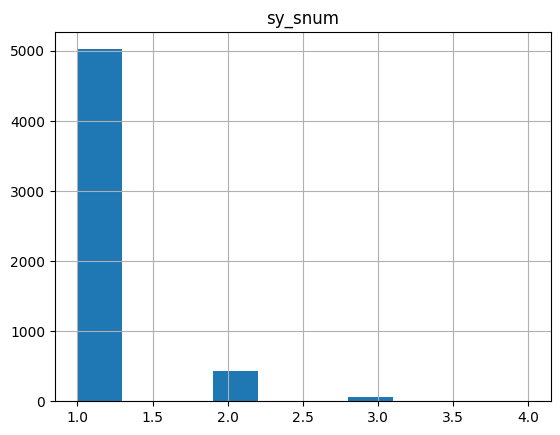

In [20]:
data.hist(column='sy_snum');